# Clustering de clientes
Eric Salazar Moreira  

A partir del dataset recibido, el cuál contiene datos de las compras de clientes realizadas con tarjeta de crédito, debemos conseguir segmentar a los clientes en distintos grupos mediante un algoritmo de clustering entre: DBScan, K-means, Herarchical Clustering o Gaussian Mixture.

## Importaciones y carga del dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering


warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = (8, 6); 
sns.set(color_codes=True)
df = pd.read_csv('credit_card.csv')


## Exploración inicial

In [2]:
## Una vista a la estructura general del dataframe
print(df.head())

  CUST_ID      BALANCE  BALANCE_FREQUENCY  PURCHASES  ONEOFF_PURCHASES  \
0  C10001    40.900749           0.818182      95.40              0.00   
1  C10002  3202.467416           0.909091       0.00              0.00   
2  C10003  2495.148862           1.000000     773.17            773.17   
3  C10004  1666.670542           0.636364    1499.00           1499.00   
4  C10005   817.714335           1.000000      16.00             16.00   

   INSTALLMENTS_PURCHASES  CASH_ADVANCE  PURCHASES_FREQUENCY  \
0                    95.4      0.000000             0.166667   
1                     0.0   6442.945483             0.000000   
2                     0.0      0.000000             1.000000   
3                     0.0    205.788017             0.083333   
4                     0.0      0.000000             0.083333   

   ONEOFF_PURCHASES_FREQUENCY  PURCHASES_INSTALLMENTS_FREQUENCY  \
0                    0.000000                          0.083333   
1                    0.000000       

In [3]:
## Saber el número total de filas y columnas
num_filas, num_columnas = df.shape
print("Número total de filas:", num_filas)
print("Número total de columnas:", num_columnas)

Número total de filas: 8950
Número total de columnas: 18


In [4]:
## Saber el tipo de datos de cada columna
tipos_de_datos = df.dtypes
print(tipos_de_datos)

CUST_ID                              object
BALANCE                             float64
BALANCE_FREQUENCY                   float64
PURCHASES                           float64
ONEOFF_PURCHASES                    float64
INSTALLMENTS_PURCHASES              float64
CASH_ADVANCE                        float64
PURCHASES_FREQUENCY                 float64
ONEOFF_PURCHASES_FREQUENCY          float64
PURCHASES_INSTALLMENTS_FREQUENCY    float64
CASH_ADVANCE_FREQUENCY              float64
CASH_ADVANCE_TRX                      int64
PURCHASES_TRX                         int64
CREDIT_LIMIT                        float64
PAYMENTS                            float64
MINIMUM_PAYMENTS                    float64
PRC_FULL_PAYMENT                    float64
TENURE                                int64
dtype: object


In [5]:
## Saber si contamos con valores nulos en las columnas
valores_nulos = df.isnull().sum()
print(valores_nulos)

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64


In [6]:
## Ver si en las columnas numéricas hay ceros
columnas_numericas = df.select_dtypes(include=['int', 'float'])
registros_con_0 = (columnas_numericas == 0).sum()
print(registros_con_0)

BALANCE                               80
BALANCE_FREQUENCY                     80
PURCHASES                           2044
ONEOFF_PURCHASES                    4302
INSTALLMENTS_PURCHASES              3916
CASH_ADVANCE                        4628
PURCHASES_FREQUENCY                 2043
ONEOFF_PURCHASES_FREQUENCY          4302
PURCHASES_INSTALLMENTS_FREQUENCY    3915
CASH_ADVANCE_FREQUENCY              4628
CASH_ADVANCE_TRX                    4628
PURCHASES_TRX                       2044
CREDIT_LIMIT                           0
PAYMENTS                             240
MINIMUM_PAYMENTS                       0
PRC_FULL_PAYMENT                    5903
TENURE                                 0
dtype: int64


**Explicación de cada columna**
- **CUST_ID:** Identificación del titular de la tarjeta de crédito (Categórico)
- **BALANCE:** Monto de saldo restante en su cuenta para hacer compras
- **BALANCE_FREQUENCY:** Con qué frecuencia se actualiza el saldo, puntaje entre 0 y 1 (1 = actualizado con frecuencia, 0 = no actualizado con frecuencia)
- **PURCHASES:** Monto de compras realizadas desde la cuenta
- **ONEOFF_PURCHASES:** Monto máximo de compra realizada de una sola vez
- **INSTALLMENTS_PURCHASES:** Monto de compra realizada en cuotas
- **CASH_ADVANCE:** Dinero en efectivo adelantado dado por el usuario
- **PURCHASES_FREQUENCY:** Con qué frecuencia se realizan las compras, puntaje entre 0 y 1 (1 = compras frecuentes, 0 = compras no frecuentes)
- **ONEOFFPURCHASESFREQUENCY:** Con qué frecuencia se realizan compras de una sola vez (1 = compras frecuentes, 0 = compras no frecuentes)
- **PURCHASESINSTALLMENTSFREQUENCY:** Con qué frecuencia se realizan compras a plazos (1 = frecuentemente realizadas, 0 = no frecuentemente realizadas)
- **CASHADVANCEFREQUENCY:** Con qué frecuencia se paga el dinero en efectivo por adelantado
- **CASHADVANCETR:** Número de transacciones realizadas con "Dinero en efectivo adelantado"
- **PURCHASES_TRX:** Número de transacciones de compra realizadas
- **CREDIT_LIMIT:** Límite de la tarjeta de crédito para el usuario
- **PAYMENTS:** Monto de pago realizado por el usuario
- **MINIMUM_PAYMENTS:** Monto mínimo de pagos realizados por el usuario
- **PRCFULLPAYMENT:** Porcentaje del pago completo realizado por el usuario
- **TENURE:** Antigüedad del servicio de tarjeta de crédito para el usuario

## Análisis de los datos

### Distribución de cada columna

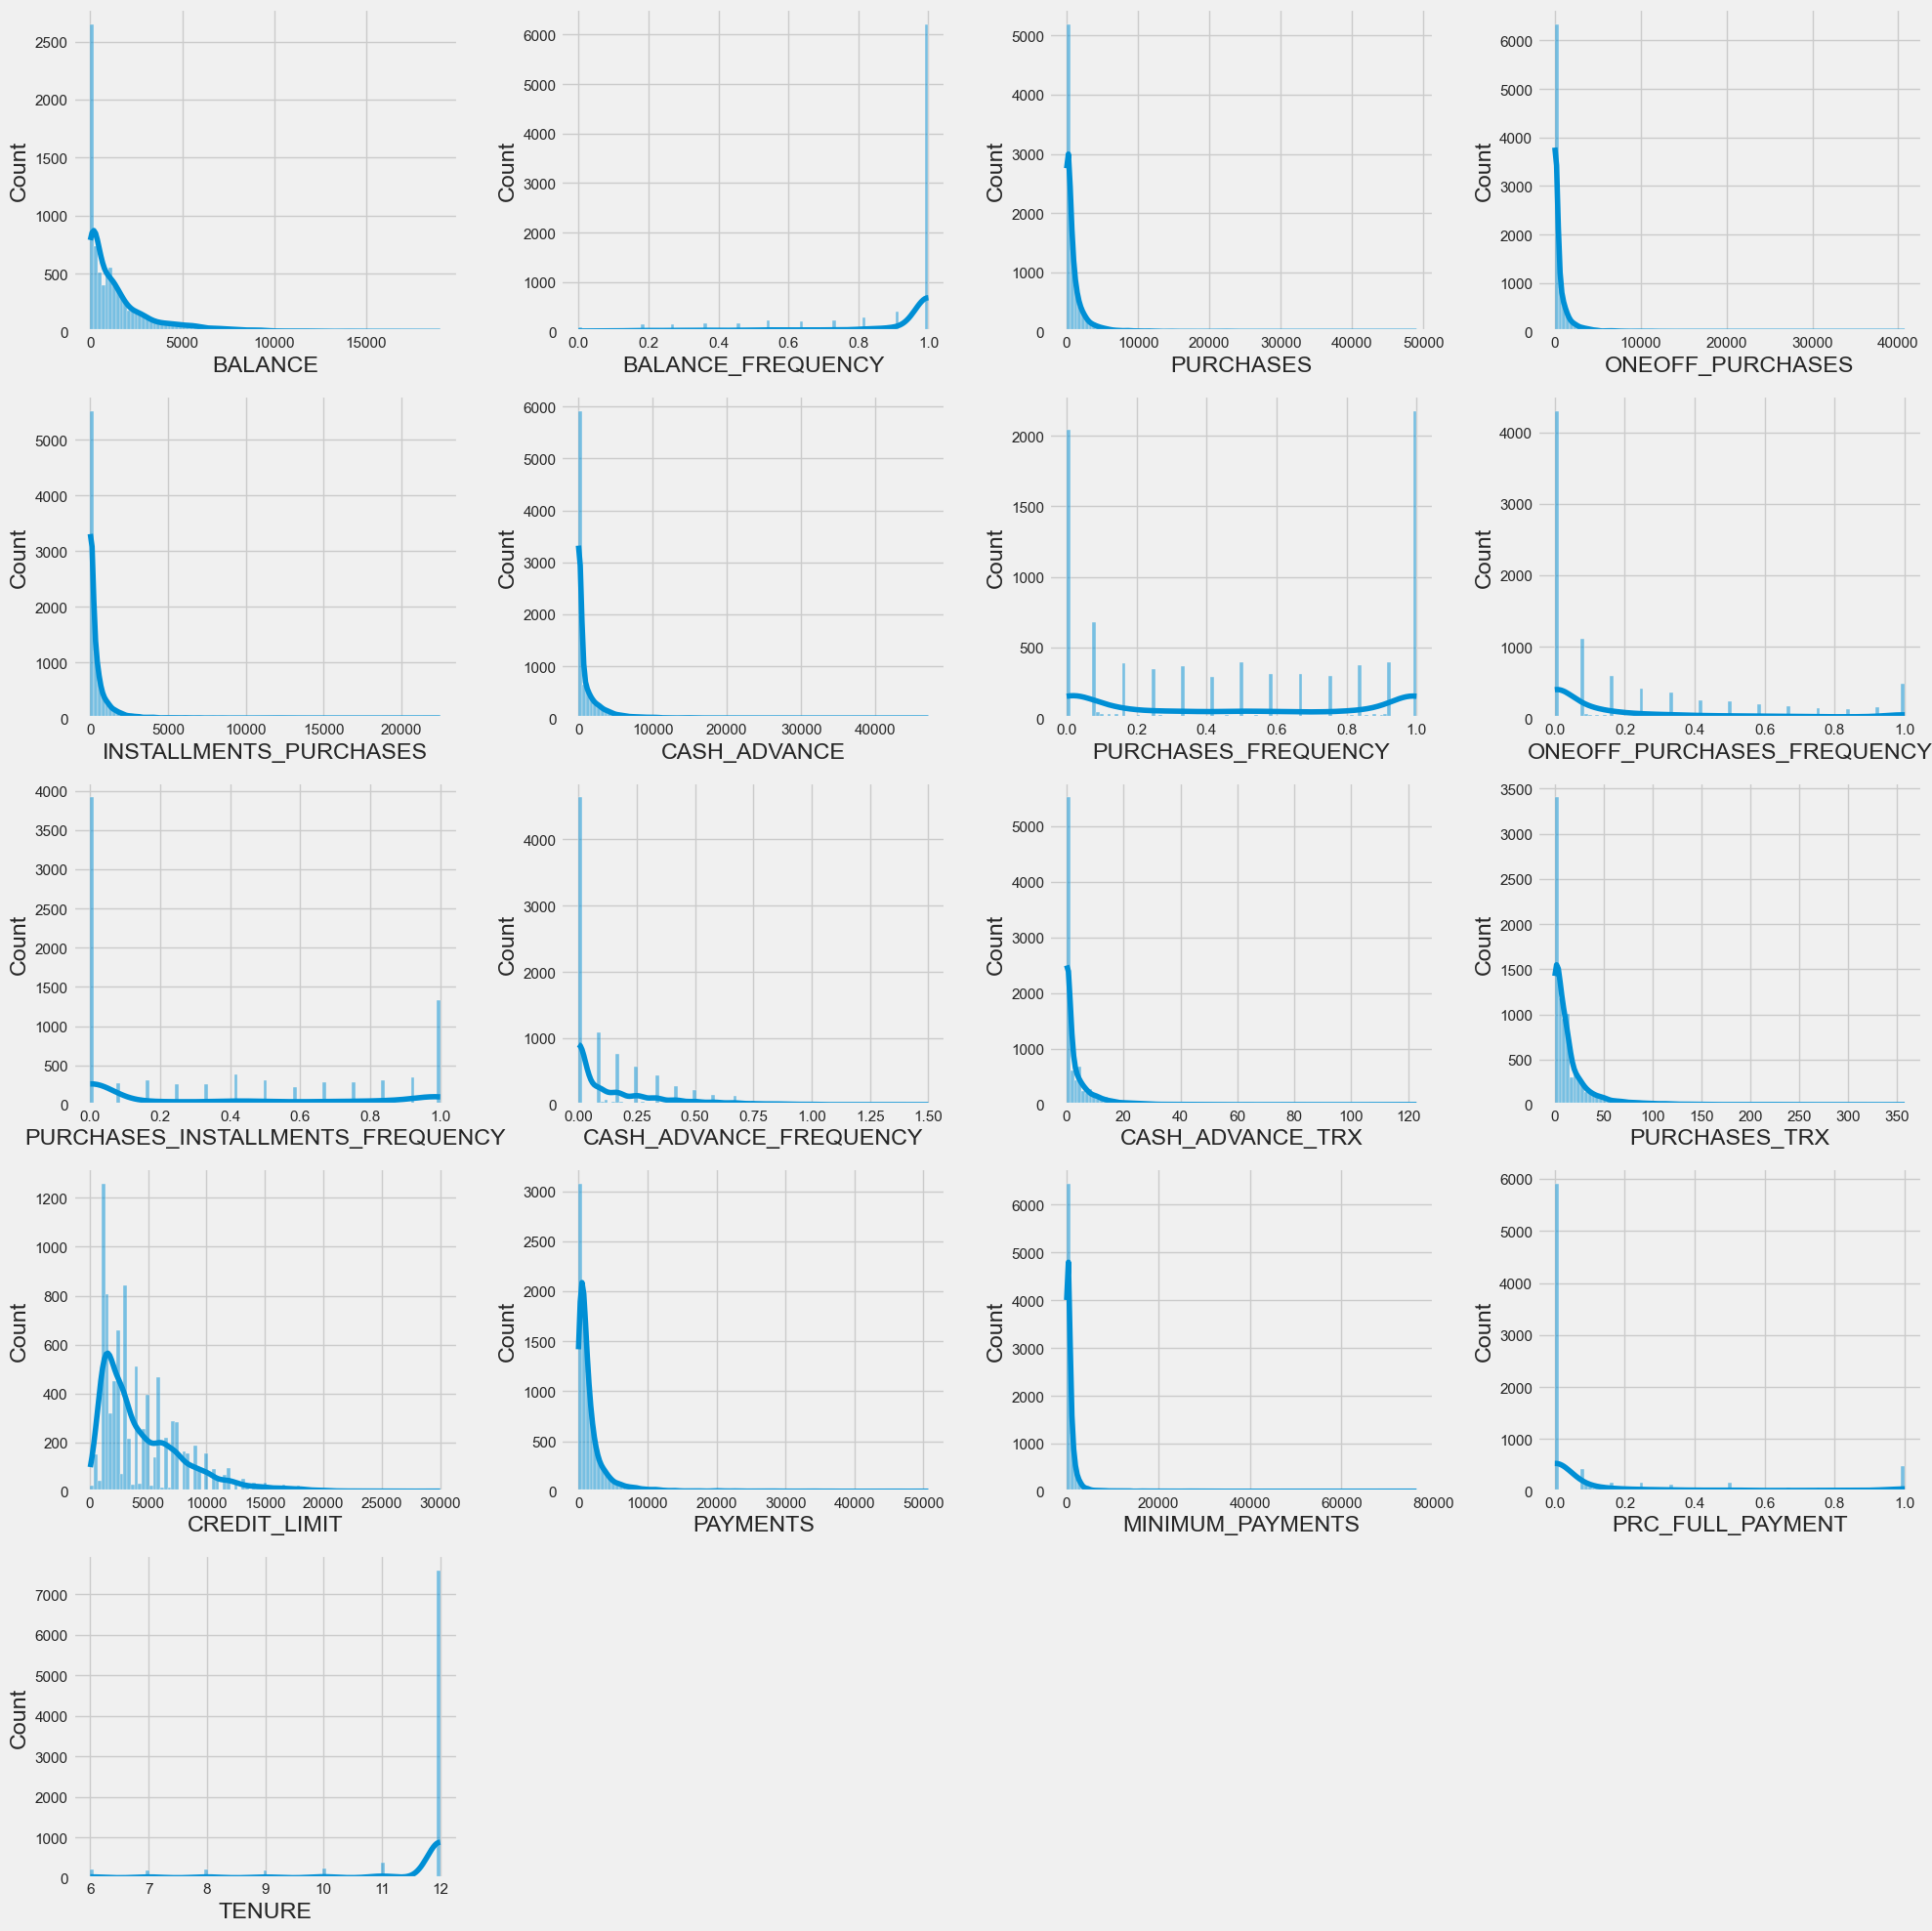

In [7]:
plt.style.use("fivethirtyeight")

columns = df[['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES','ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE','PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY','PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY','CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS','MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE']]

plt.figure(figsize=(20, 20)) 
for i, col in enumerate(columns):
    plt.subplot(5, 4, i + 1)  
    sns.histplot(data=columns, x=col, kde=True, bins=round(np.sqrt(len(df))))
    plt.tight_layout() 
plt.show()


### Histogramas

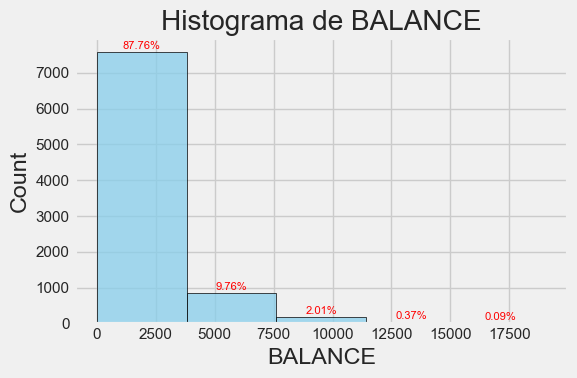

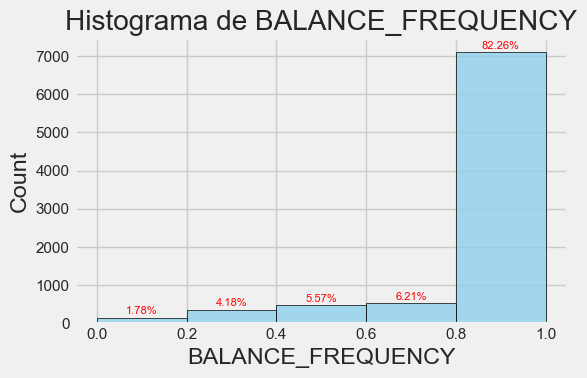

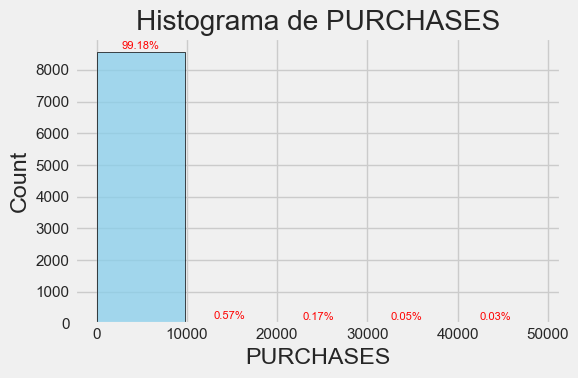

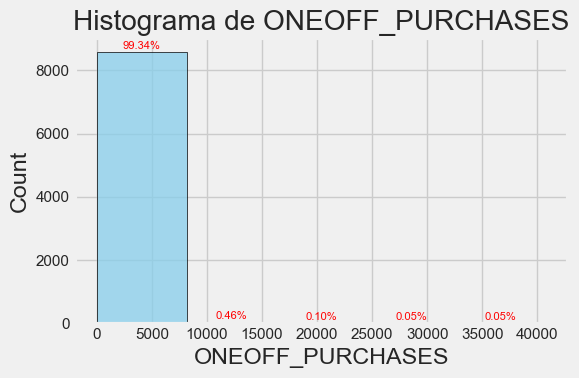

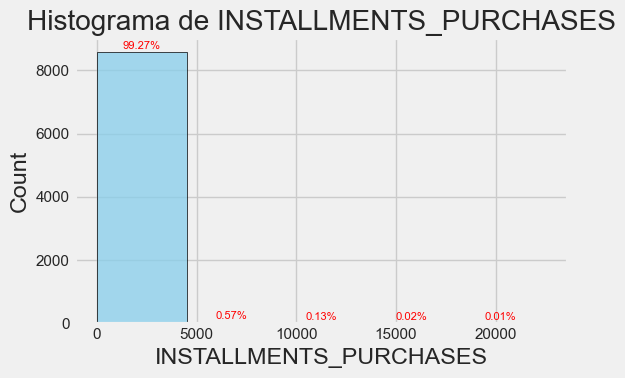

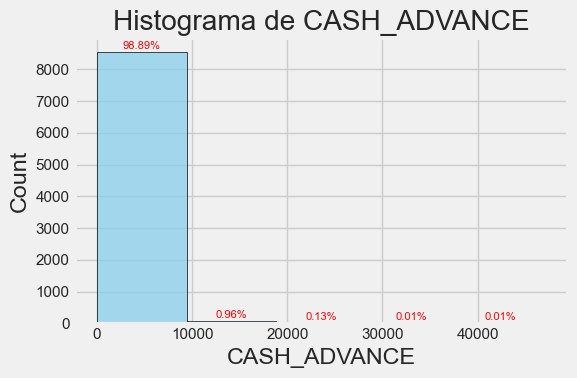

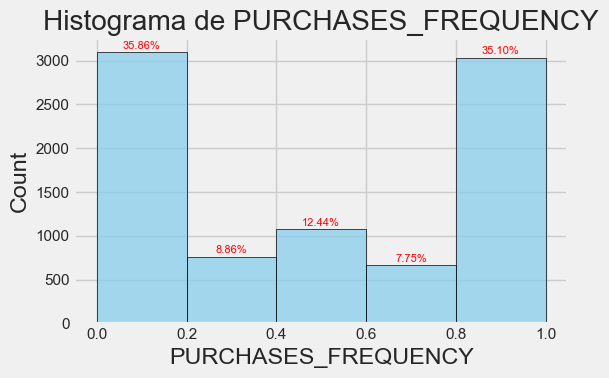

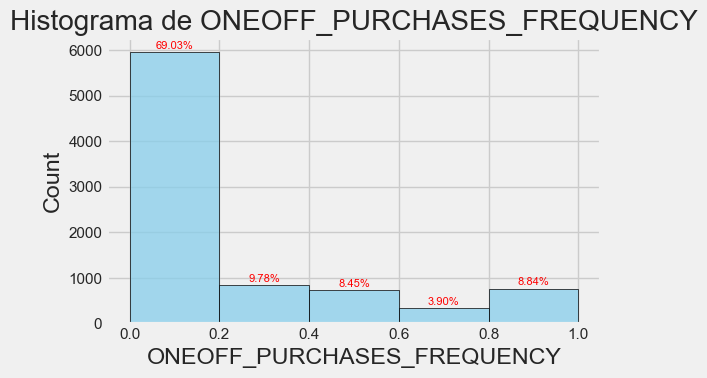

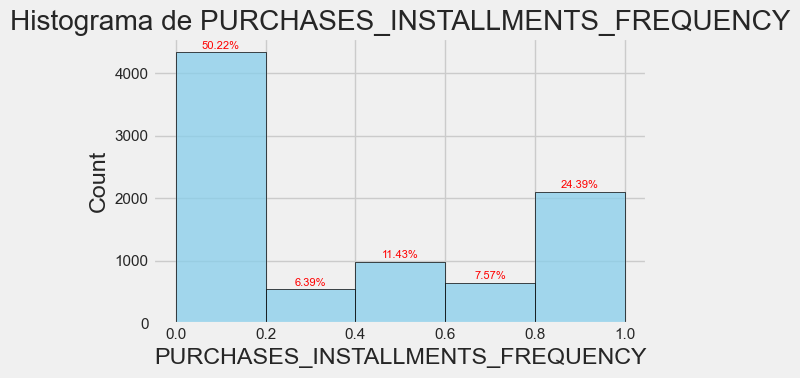

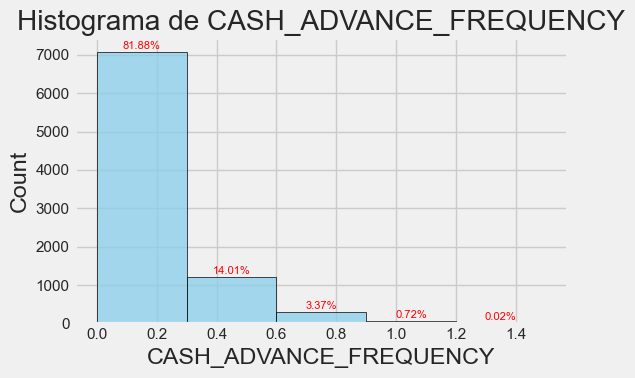

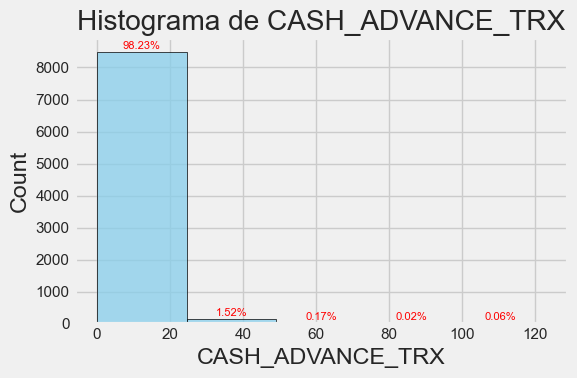

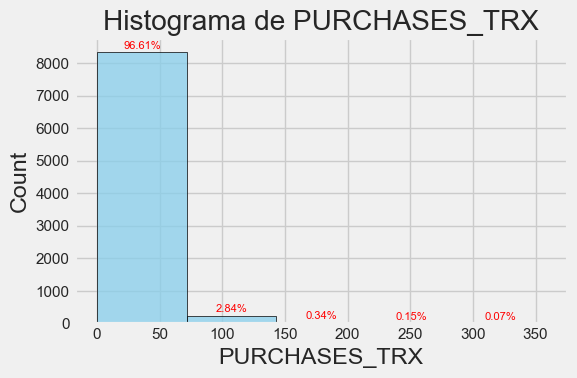

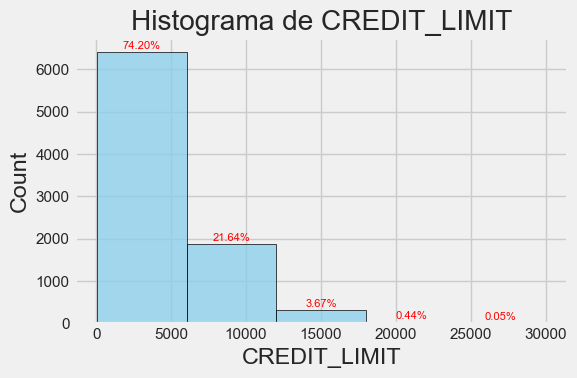

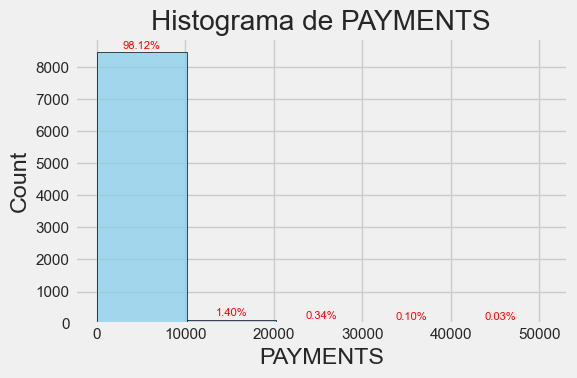

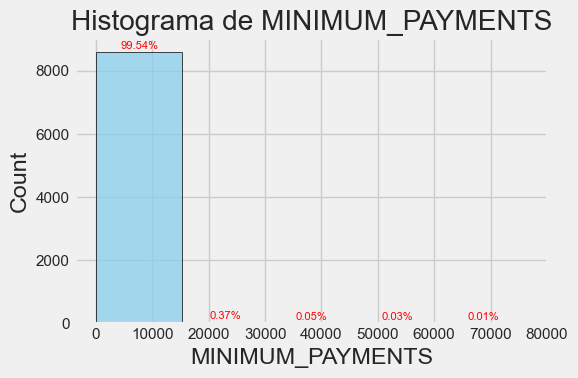

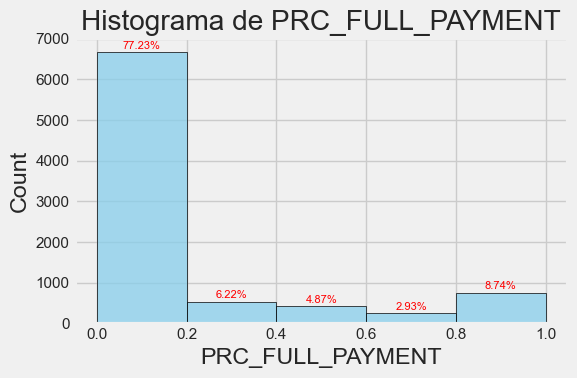

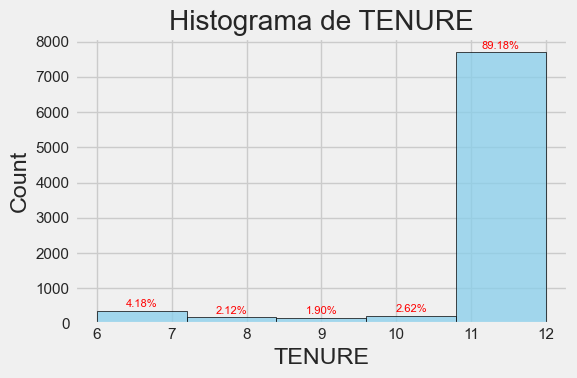

In [8]:

columns_of_interest = ['BALANCE', 'BALANCE_FREQUENCY', 'PURCHASES',
       'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'TENURE'] 
selected_data = df[columns_of_interest].dropna()

for column in columns_of_interest:
    plt.figure(figsize=(6, 4))
    sns.histplot(selected_data[column], bins=5, kde=False, color='skyblue', edgecolor='black')
    plt.xlabel(f'{column}')
    plt.ylabel('Count')
    plt.title(f'Histograma de {column}')

    # Etiquetas con los porcentajes
    counts, bins = np.histogram(selected_data[column], bins=5)
    percentages = (counts / len(selected_data[column])) * 100

    for count, bin_edge, percentage in zip(counts, bins[:-1], percentages):
        plt.annotate(f'{percentage:.2f}%', xy=(bin_edge + np.diff(bins)[0] / 2, count), xytext=(0, 1),
                     textcoords='offset points', ha='center', va='bottom', fontsize=8, color='red')

    plt.tight_layout()
    plt.show()

**Puntos a tener en cuenta**
- La mayoría de clientes actualizan sus cuentas con una frecuencia alta y el balance del 87% no supera los 3500 dólares.
- El 74% de los clientes tienen límites de crédito que no superan los 6000 dólares.
- Solamente el 35% de los clientes compran con frecuencia alta.
- El 96% de los clientes no han hecho más de 70 compras.
- El 89% de los clientes tienen una antigüedad de más de 11 meses.
- El 95% de los clientes no utilizan el pago por adelantado con frecuencia pero el 99% lo han llegado a utilizar.
- El 78% de los clientes no hace compras one-go, por lo que prefieren realizar compras pequeñas.
- La frecuencia es bastante más alta en compras pagadas a plazos que en compras pagadas de golpe.
- Casi la totalidad de los clientes tienen pagos mínimos por debajo de 15000 dólares.
- El total de pagos hechos por el 98% de los clientes están por debajo de los 10000 dólares.

### Correlación entre columnas

<Axes: >

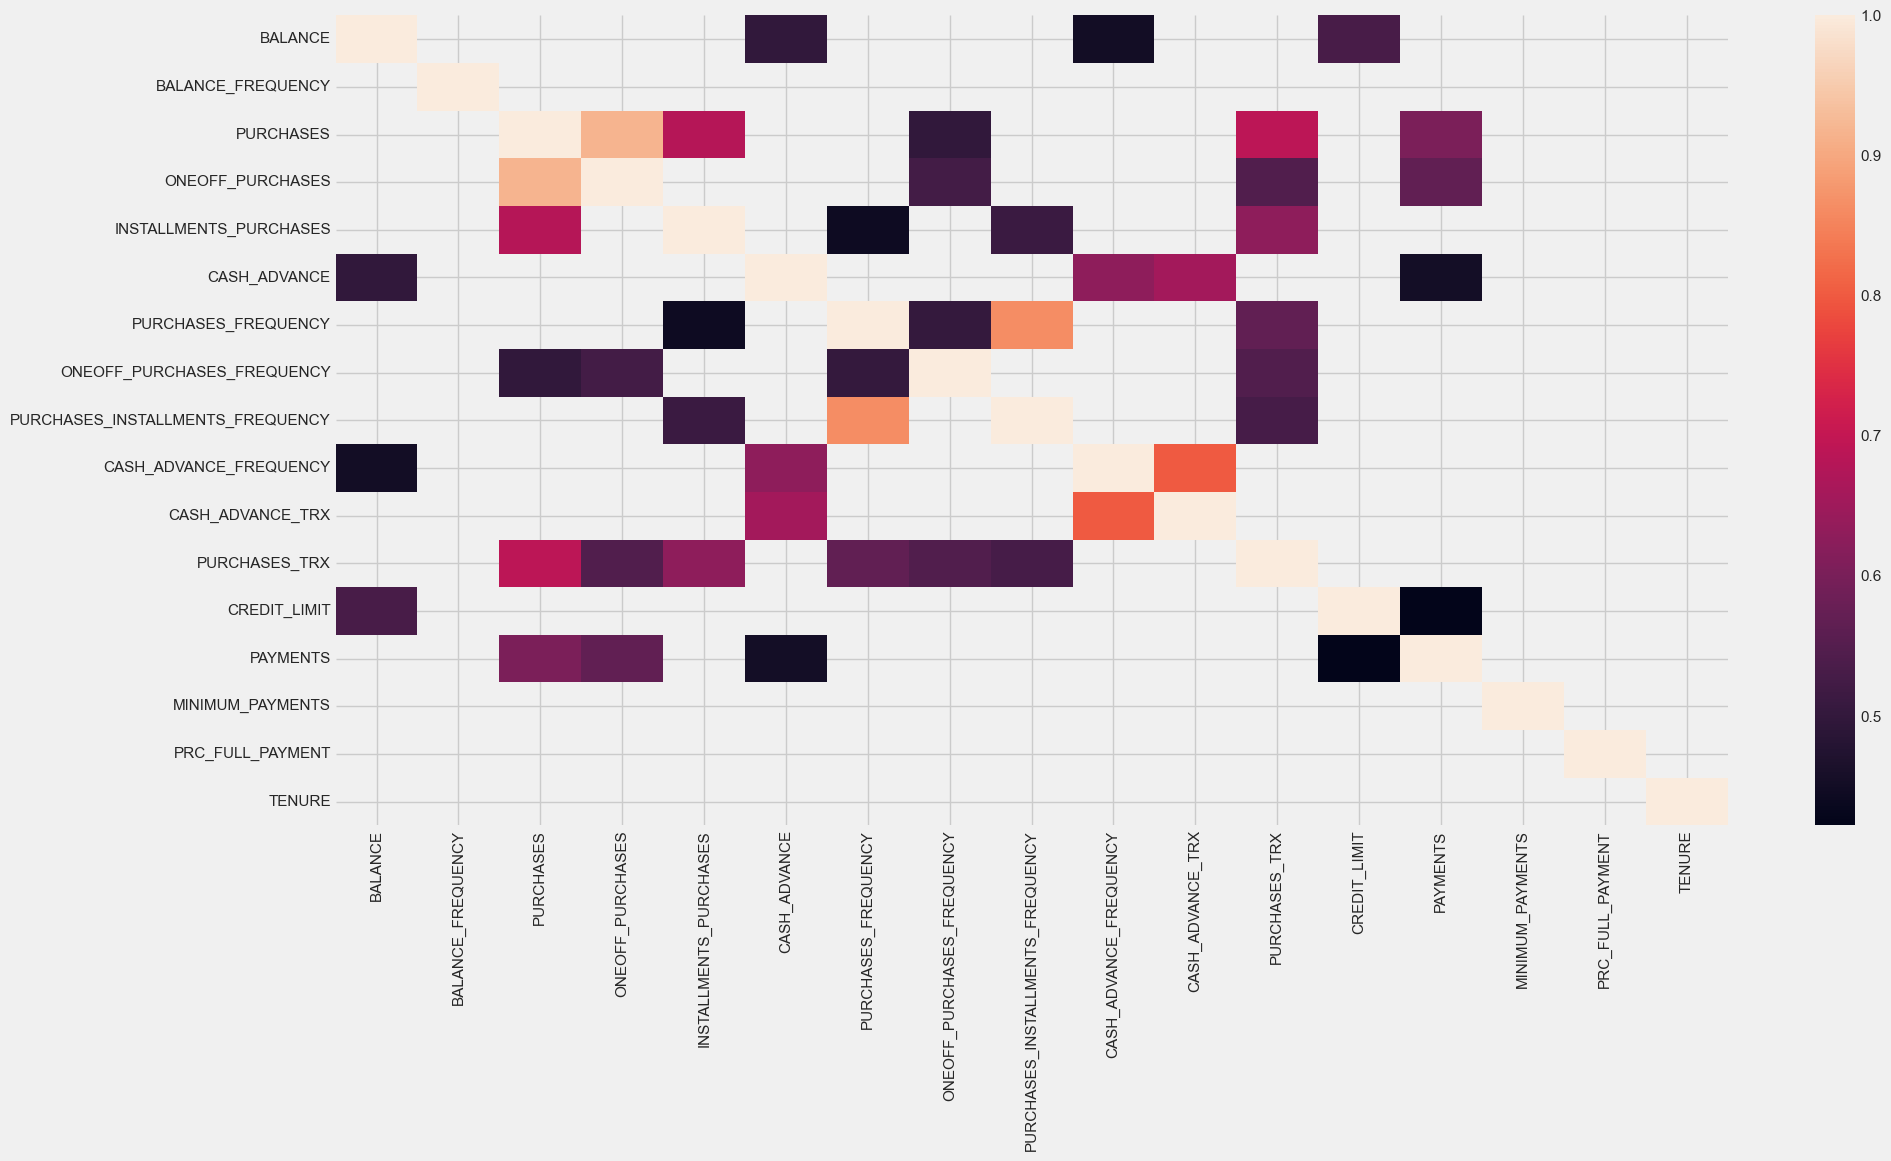

In [9]:
## Pongo un thresh de 0.4 para ver solamente las correlaciones más destacadas

plt.figure(figsize=(20,10))
correlation = df.iloc[:,1:].corr()
thresh = 0.4
sns.heatmap(correlation[abs(correlation) > thresh] , annot=False)

No encontramos correlaciones del todo altas que no sean obvias, pero algunas columnas correlacionadas son:
- "PURCHASES_FREQUENCY" y "PURCHASES_INSTALLMENTS_FREQUENCY"
- "PURCHASES" y "ONEOFF_PURCHASES"
- "CASH_ADVANCE_TRX" y "CASH_ADVANCE_FREQUENCY"
- "PURCHASES" y "PURCHASES_TRX

## Preparación de los datos
A partir de investigar y también ver trabajos de algunos científicos de datos, he visto que es una buena práctica eliminar filas que contengan valores en nulo o que tengan correlaciones altas para poder realizar el algoritmo de clustering de la forma más eficiente.  
  
En este caso eliminaré los registros con filas en nulo y eliminaré las columnas "PURCHASES_INSTALLMENTS_FREQUENCY", "ONEOFF_PURCHASES" y "CASH_ADVANCE_FREQUENCY", ya que generan las correlaciones más altas y además pueden ser calculadas mediante otras columnas. También eliminaré "CUST_ID" puesto que no me sirve para nada.  
  
También es algo bastante importante realizar transformaciones logarítmicas cuando tenemos datos con escalas grandes o cuando estos están muy extremizados y no son uniformes o simétricos. En nuestro caso, esto ocurre en la mayoría de columnas, donde hay valores sesgados hacia números más altos o bajos y donde los extremos dominan. Al transformar datos logarítmicamente, se consigue que los datos estén mejor distribuidos en una escala logarítmica y facilita al algoritmo los agrupamientos.  
  
"Sin embargo, en la práctica, los datos pueden tener distribuciones que son muy sesgadas o asimétricas, con una gran cantidad de puntos concentrados en un extremo y muy pocos puntos en el otro. Esta distribución sesgada puede hacer que el algoritmo de agrupamiento tenga dificultades para identificar los grupos de manera precisa, ya que los centroides se pueden desplazar hacia el extremo con más puntos."  
  
Sabiendo esto, realizaré transformaciones en los campos con números más sesgados o extremizados.

In [10]:
## Realizo una copia del dataframe
df_copia = df.copy()

In [11]:
## Eliminación de filas con registros nulos
df_copia.dropna(inplace=True)

## Comprobación
valores_nulos = df_copia.isnull().sum()
print(valores_nulos)

CUST_ID                             0
BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64


In [12]:
## Eliminación de columnas
df_copia.drop(columns=['CUST_ID', 'PURCHASES_INSTALLMENTS_FREQUENCY','ONEOFF_PURCHASES', 'CASH_ADVANCE_FREQUENCY' ], inplace=True)

In [13]:
## Transformación logarítmica
df_copia.skew()
skewness_features = ['BALANCE', 'PURCHASES', 'INSTALLMENTS_PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT',
                     'PAYMENTS', 'MINIMUM_PAYMENTS', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX']
df_copia[skewness_features] = np.log(df_copia[skewness_features] + 0.1)

## He sacado de la transformación a los campos Tenure y las frecuencias, puesto que la escala donde se mueven, ya está muy reducida, de 0 a 12 en Tenure y 
# de 0-1 en frecuencias, por lo que estos datos ya son fáciles de interpretar para el algoritmo

In [14]:
df_copia.skew()

BALANCE                      -0.904675
BALANCE_FREQUENCY            -2.084161
PURCHASES                    -0.980708
INSTALLMENTS_PURCHASES       -0.140807
CASH_ADVANCE                  0.170686
PURCHASES_FREQUENCY           0.033041
ONEOFF_PURCHASES_FREQUENCY    1.504234
CASH_ADVANCE_TRX              0.393508
PURCHASES_TRX                -0.599293
CREDIT_LIMIT                 -0.107283
PAYMENTS                     -0.109795
MINIMUM_PAYMENTS              0.101950
PRC_FULL_PAYMENT              1.886027
TENURE                       -3.011141
dtype: float64

## Elección del algoritmo
Después de leer bastante sobre varios algoritmos: K-means, DBScan, Hierarchical y Gaussian. He llegado a la conclusión de utilizar Gaussian, aunque con otros algoritmos también podría haber realizado un trabajo de clustering eficiente y lo realmente interesante sería probarlos todos y ver el resultado, pero en esta práctica debo de escoger uno y ha sido Gaussian por los siguientes puntos:


- **Adecuación a la naturaleza de los datos:**
Los datos de compras con tarjetas de crédito suelen tener una distribución compleja y pueden contener clusters con formas elipsoidales o superpuestas. Dado que los campos del dataframe son todos numéricos, GMM es una opción adecuada para modelar la estructura de estos datos y capturar la complejidad de los clusters presentes.

- **Modelado de distribuciones complejas:**
GMM es capaz de modelar distribuciones complejas en los datos, lo que incluye clusters con formas irregulares, tamaños diferentes y superposiciones. Esta capacidad permite identificar patrones sutiles y clusters que podrían ser difíciles de capturar con otros algoritmos de clustering.

- **Flexibilidad en la asignación de puntos a clusters:**
GMM asigna probabilidades a cada punto de datos para pertenecer a cada cluster, en lugar de asignarlos de forma rígida. Esta flexibilidad en la asignación de puntos a clusters permite manejar mejor regiones de superposición entre clusters y proporciona una mejor interpretación de la incertidumbre en la asignación de clusters.

- **Evaluación de la calidad de los clusters:**
GMM proporciona una medida natural de la calidad de los clusters a través de la probabilidad logarítmica de los datos dado el modelo (log-likelihood). Esto permite evaluar la adecuación del modelo a los datos y comparar diferentes configuraciones de clusters.

## Definición del número de clusters


Para definir el número de clusters he utilizado dos métodos, el T-SNE y el método del codo:

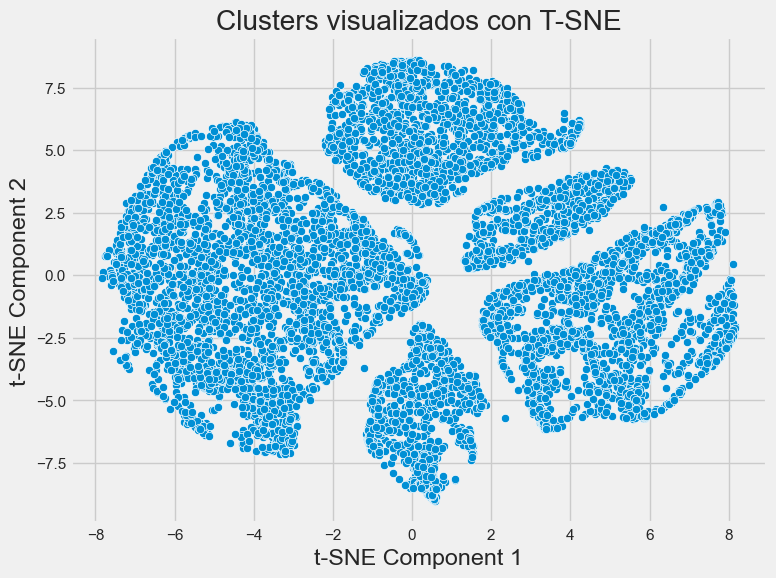

In [16]:
rcParams['figure.figsize'] = (8, 6)
tsne = TSNE(n_components=2,  perplexity=30, learning_rate=0.1, n_iter=2000)
X_tsne = tsne.fit_transform(df_copia)

df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])

sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', data=df_tsne)
plt.title('Clusters visualizados con T-SNE')
plt.show()

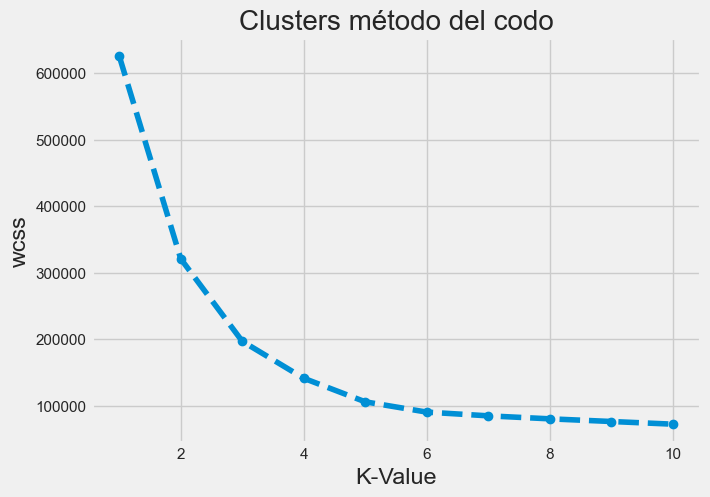

In [17]:
rcParams['figure.figsize'] = (7, 5)
wcss= []

for i in range(1,11): 
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=300, random_state=42)
    km.fit(df_copia)
    wcss.append(km.inertia_)
    
plt.plot(range(1,11),wcss, marker='o', linestyle='--')
plt.title('Clusters método del codo', fontsize =20)
plt.xlabel('K-Value')
plt.ylabel('wcss')
plt.show()

En los dos métodos se refleja que el número de clusters óptimo es 5, por lo que utilizaré este número en el algoritmo GMM.

## Aplicación del algoritmo

In [18]:
# Número de clusters
n_clusters = 5

# Inicio del algoritmo
gaussian_model = GaussianMixture(n_components=n_clusters,covariance_type='full')
labels_ = gaussian_model.fit_predict(df_copia)

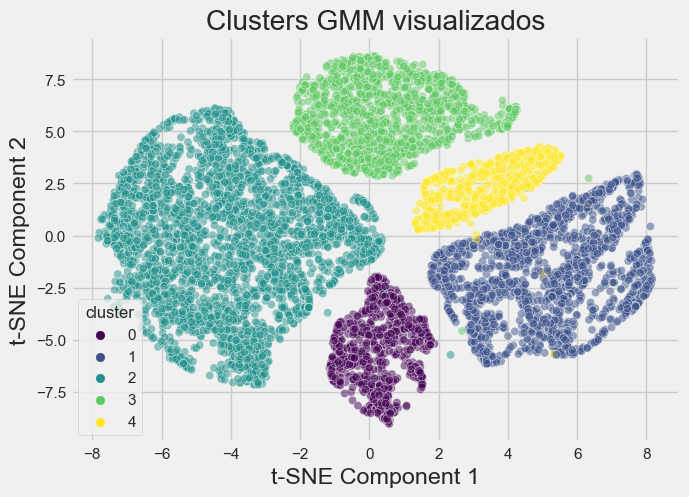

In [19]:

df_tsne['cluster'] = labels_

# Ploteamos
sns.scatterplot(x='t-SNE Component 1', y='t-SNE Component 2', hue='cluster', data=df_tsne, palette='viridis',alpha=0.5)
plt.title('Clusters GMM visualizados')
plt.show()

## Conclusiones

In [23]:
## Realizo un nuevo df con las columnas del original y agrupándolo en los clusters hago medias para verlo más claro

final_df = df.copy()
final_df.dropna(inplace=True)
final_df.drop(columns=['CUST_ID'],inplace=True)
final_df['Cluster'] = labels_
cols = ['PURCHASES', 'ONEOFF_PURCHASES' ,'PURCHASES_FREQUENCY','PAYMENTS', 'CASH_ADVANCE','CREDIT_LIMIT' ,'INSTALLMENTS_PURCHASES', 'PURCHASES_TRX',
        'CASH_ADVANCE_TRX', 'CASH_ADVANCE_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
        'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'TENURE']
clusters = final_df['Cluster'].unique()
final_df.groupby('Cluster')[cols].mean()



,PURCHASES,ONEOFF_PURCHASES,PURCHASES_FREQUENCY,PAYMENTS,CASH_ADVANCE,CREDIT_LIMIT,INSTALLMENTS_PURCHASES,PURCHASES_TRX,CASH_ADVANCE_TRX,CASH_ADVANCE_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,TENURE
Cluster,,,,,,,,,,,,,,
0,905.917936,905.917936,0.362812,1215.257410,0.000000,4426.431312,0.000000,8.019940,0.000000,0.000000,0.362812,0.000000,0.000000,11.608175
1,0.000000,0.000000,0.000000,1714.954091,2010.280003,4050.722052,0.000000,0.000000,6.416922,0.277159,0.000000,0.000000,0.277159,11.358308
2,1526.897617,766.299635,0.764564,1552.948796,0.000000,4428.271646,761.169452,23.477830,0.000000,0.000000,0.233228,0.663467,0.000000,11.658401
3,1498.788444,799.547324,0.739378,2707.667850,2080.362340,5367.720895,699.737795,24.808874,7.273038,0.282685,0.272615,0.621684,0.282685,11.529693
4,664.628728,664.628728,0.276917,1975.408588,2048.585635,4655.172938,0.000000,6.370180,6.907455,0.296183,0.276917,0.000000,0.296183,11.345758


**Cluster 0**
- Los clientes de este cluster muestran una preferencia por realizar compras únicas en lugar de optar por pagos a plazos.
- La mayoría de las compras realizadas por los clientes en este cluster son transacciones únicas, lo que indica que prefieren realizar compras de pago único.
- El número de transacciones de compra es relativamente menor en comparación con los demás clusters, con un promedio de 8 transacciones.
- El 36% de los clientes en este cluster compran de forma frecuente.
- La cantidad promedio de compras totales es de 903, lo que refleja la tendencia a compras únicas con una cantidad de gasto moderado.  
  
**Cluster 1**
- Los clientes de este cluster muestran una preferencia por utilizar adelantos en efectivo en lugar de realizar compras a plazos.
- La mayoría de las compras realizadas por los clientes en este cluster son a través de adelantos en efectivo, lo que indica que cuentan con fondos.
- La frecuencia de compra de estos clientes es baja.  
  

**Cluster 2**
- Los clientes de este cluster muestran una preferencia por realizar compras a plazos en lugar de optar por adelantos en efectivo.
- La cantidad promedio de compras realizadas a plazos es de 761.84, lo que indica que una parte significativa de sus gastos ocurre a través de pagos a plazos.
- La frecuencia de compra de estos clientes es alta.
- La cantidad promedio de compras totales es de 1528, lo que sugiere que aunque las compras son frecuentes, son de tamaño moderado.  
  

**Cluster 3**
- Los clientes de este cluster muestran una preferencia por realizar compras tanto a plazos como a través de adelantos en efectivo.
- La cantidad promedio de compras realizadas a plazos es de 701.84, lo que indica una parte significativa de sus gastos ocurre a través de pagos a plazos.
- La frecuencia de compra de estos clientes es alta, con un promedio de 25 transacciones.
- La cantidad promedio de compras totales es de 1501, lo que sugiere que aunque las compras son frecuentes, son de tamaño moderado.
- La cantidad promedio de adelantos en efectivo tomados por los clientes en este cluster es de 2080.54, lo que sugiere una dependencia de fondos inmediatos para sus compras.  
  
**Cluster 4**
- Los clientes de este cluster muestran una preferencia por utilizar adelantos en efectivo en lugar de realizar compras a plazos.
- La cantidad promedio de compras realizadas por los clientes en este cluster es de $669, lo que indica un nivel moderado de gasto en compras.
- La frecuencia de compra de estos clientes es baja, con un promedio de 6 transacciones.
- La cantidad promedio de adelantos en efectivo tomados por los clientes en este cluster es de 2046.54. Esto sugiere que los clientes en el cluster 4 dependen en gran medida de adelantos en efectivo para satisfacer sus necesidades financieras, lo que indica una posible inestabilidad financiera o gastos inesperados entre este grupo de clientes.  
  
A partir de estas agrupaciones, obtenemos 5 tipos de cliente bastante diferenciados y somos capaces de categorizar a los usuarios dependiendo del resto de características para después poder realizar un mejor trabajo.
